## Replicate model in Preisler et al. (2017)

Their approach was to use a general additive model with a logit link function. GAMs are hard to implement in Python and do not play well with tensorflow. We will approximate this with a dense neural network with a logit activation function in the output node.

In [1]:
import os

if "notebooks" in os.getcwd():
    os.chdir("..")
    print("Changed working directory to", os.getcwd())

import util

import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import cartopy.crs as ccrs

import shutil
import json
import random

from google.cloud.storage import Client

Changed working directory to /home/jovyan/ForestLST


/home/jovyan/ForestLST/util/__init__.py:21: UserWarning: Earth Engine API not found! Module util.gee will not be loaded.
  warnings.warn("Earth Engine API not found! Module util.gee will not be loaded.")


### Get data from GCS

In [2]:
ds = util.data.make_preisler_dataframe().reset_index()
ds.head()

,latitude,longitude,year,fire,mort,mort1,mtemp1,near1,prec1,prec2,prec3,prec4,prism_prec,rhost1
0,32.597501,-116.691155,2013,0.0,0.0,0.0,-0.216653,0.0000,369.805910,439.905603,480.046706,265.648307,415.772351,0.0
1,32.597501,-116.691155,2014,0.0,0.0,0.0,-2.696189,0.0000,247.394694,369.805910,439.905603,480.046706,415.772351,0.0
2,32.597501,-116.655223,2012,0.0,0.0,0.0,-1.278424,0.0000,448.261502,487.811619,267.075369,285.700573,417.824220,0.0
3,32.597501,-116.655223,2013,0.0,0.0,0.0,-0.367448,0.0000,364.210992,448.261502,487.811619,267.075369,417.824220,0.0
4,32.597501,-116.655223,2014,0.0,0.0,0.0,-3.270955,0.0016,257.534478,364.210992,448.261502,487.811619,417.824220,0.0


## Blocking data

Tree mortality exhibits spatial and temporal autocorrelation. That is, pixels that are close in space or close in time are more similar to each other. We must account for this in order to have a model that generalizes well. Preisler et al. (2017) and Rao et al. (2019) both used a random train/test split. This probably results in an overestimation of model performance on the test set. To quantify this effect we will test three splitting strategies:
 - Random
 - Spatial blocking
 - Temporal blocking

In each case, we will use a 70/30 train/valid split with two years of data held out for final testing. This mimics how this model would be used operationally to predict across all of California in the future.

Note that the data above have already been shifted such that this is a forecasting problem.

In [3]:
test_years = [2006, 2016]
trainval_idx = ds.year.isin(test_years)
ds_trainval = ds[~trainval_idx]
ds_test     = ds[ trainval_idx]

In [4]:
# Random split - this one is easy just call train_test_split twice
def random_split(df):
    train, valid = train_test_split(df, train_size=0.7, test_size=0.3)
    return train, valid

In [5]:
train, valid = random_split(ds_trainval)
assert train.shape[0] > valid.shape[0]

In [6]:
# Spatial split - group observations into 0.50-degree blocks and split
def spatial_split(df, coords=["latitude", "longitude"], blocksize=0.50):
    mindex = pd.MultiIndex.from_tuples(zip(*(
        np.round(df[c]/blocksize)*blocksize
        for c in coords
    )))

    # Unlike train_test_split, GroupShuffleSplit returns indices
    train_idx, valid_idx = next(GroupShuffleSplit(1, train_size=0.7, test_size=0.3).split(df, groups=mindex))

    return (
        df.iloc[train_idx], 
        df.iloc[valid_idx]
    )

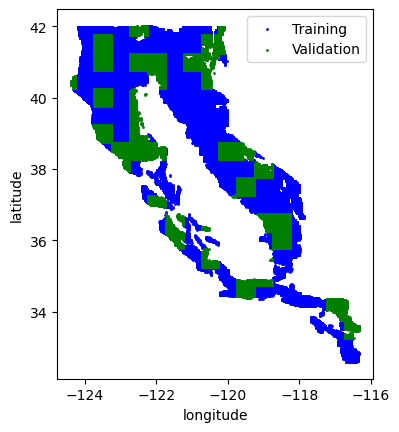

In [7]:
# Verify that it works
train, valid = spatial_split(ds_trainval)

fig, ax = plt.subplots(1, 1)

train.plot.scatter(x="longitude", y="latitude", s=1, ax=ax, label="Training", color="blue")
valid.plot.scatter(x="longitude", y="latitude", s=1, ax=ax, label="Validation", color="green")
ax.set_aspect("equal")
plt.show()

In [8]:
# Temporal split - just use GroupShuffleSplit with years instead of spatial blocks
def temporal_split(df, column="year"):
    # Unlike train_test_split, GroupShuffleSplit returns indices
    train_idx, valid_idx = next(GroupShuffleSplit(1, train_size=0.7, test_size=0.3).split(df, groups=df[column]))

    return (
        df.iloc[train_idx], 
        df.iloc[valid_idx]
    )

In [9]:
# Check that it works
train, valid = temporal_split(ds_trainval)

train_years = set(train["year"])
valid_years = set(valid["year"])

print("Years in training", train_years)
print("Years in validation", valid_years)

# Asserts to make sure we did it right
assert train_years.isdisjoint(valid_years)

Years in training {2017, 2018, 2019, 2021, 2022, 2004, 2005, 2008, 2009, 2010, 2013, 2014}
Years in validation {2020, 2023, 2007, 2011, 2012, 2015}


## Training workflow

Now that we have defined some ways of splitting data, we want to see how these influence model performance. We begin by defining a simple dense neural network with dropout. Since the output is between 0 and 1, the final layer gets a sigmoid activation function. Setting the initial bias to -2 helps convergence because `sigmoid(-2) ~= 0.1`, which approximates the mean of the data.

### Model definition

In [10]:
class SimpleDense(torch.nn.Module):
    def __init__(self, input_size, dropout: float=0.2, init_bias: float=None):
        super(SimpleDense, self).__init__()
        self.bn  = torch.nn.BatchNorm1d(input_size)
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32,  8)

        # Initialize bias for faster convergence
        self.out = torch.nn.Linear( 8,  1)
        if init_bias is not None:
            torch.nn.init.constant_(self.out.bias, init_bias)
        
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()

        self.drop = torch.nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.bn(x)
        
        x = self.fc1(x)
        x = self.drop(x)
        x = self.tanh(x)
        
        x = self.fc2(x)
        x = self.drop(x)
        x = self.tanh(x)
        
        x = self.fc3(x)
        x = self.drop(x)
        x = self.tanh(x)

        x = self.out(x)
        x = self.sigmoid(x)

        return x

In [11]:
sd = SimpleDense(13)
print(sd)

SimpleDense(
  (bn): BatchNorm1d(13, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=13, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=1, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
  (drop): Dropout(p=0.2, inplace=False)
)


### Convert inputs to tensors

In [12]:
TARGET = "mort"
EXCLUDE = ["year"]
BANDS = [c for c in ds.columns if c != TARGET and c not in EXCLUDE]

def df_to_dataloader(df):
    # Add two dimensions
    input = torch.from_numpy(df[BANDS].to_numpy().astype(np.float32))
    output = torch.unsqueeze(torch.from_numpy(df[TARGET].to_numpy().astype(np.float32)), 1)

    ds = TensorDataset(input, output)
    
    return DataLoader(ds, batch_size=512, shuffle=True)

### Training loop

In [13]:
import torchmetrics

splits = {
    "random_split": random_split,
    "spatial_split": spatial_split,
    "temporal_split": temporal_split
}

results = dict()

for name, f in splits.items():
    train, valid = f(ds_trainval)
    train_dl = df_to_dataloader(train)
    valid_dl = df_to_dataloader(valid)

    n_feats = next(iter(train_dl))[0].shape[1]
    model = SimpleDense(n_feats)
    opt = torch.optim.Adam(model.parameters(), lr=0.005)
    loss = torch.nn.MSELoss()
    metrics = [
        torchmetrics.regression.NormalizedRootMeanSquaredError(),
        torchmetrics.regression.R2Score()
    ]
        
    trainer = util.training.BaseTrainer(
        model, opt, loss, train_dl, valid_dl, 
        metrics=metrics
    )
    trainer.train()
    
    results[name] = trainer

Epoch 1/10
                                            Train           Valid
Loss                                     0.016347  tensor(0.0102)
NormalizedRootMeanSquaredError()   tensor(3.4272)  tensor(2.7397)
R2Score()                         tensor(-0.4101)  tensor(0.1040)
Epoch 2/10
                                           Train           Valid
Loss                                    0.010145  tensor(0.0098)
NormalizedRootMeanSquaredError()  tensor(2.6935)  tensor(2.6846)
R2Score()                         tensor(0.1290)  tensor(0.1397)
Epoch 3/10
                                           Train           Valid
Loss                                    0.009829  tensor(0.0095)
NormalizedRootMeanSquaredError()  tensor(2.6585)  tensor(2.6424)
R2Score()                         tensor(0.1515)  tensor(0.1665)
Epoch 4/10
                                           Train           Valid
Loss                                    0.009511  tensor(0.0094)
NormalizedRootMeanSquaredError()  tensor(2

## Visualize results

### Learning curves

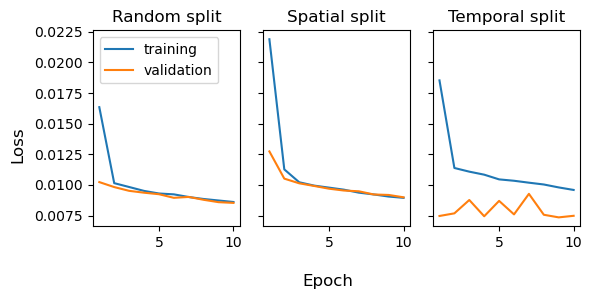

In [14]:
def learning_curve(loss, val_loss, ax):
    epoch = 1+np.arange(len(loss))

    ax.plot(epoch, loss, label="training")
    ax.plot(epoch, val_loss, label="validation")

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 3))

learning_curve(
    results["random_split"].history["Train"]["Loss"],
    results["random_split"].history["Valid"]["Loss"],
    ax[0]
)

learning_curve(
    results["spatial_split"].history["Train"]["Loss"],
    results["spatial_split"].history["Valid"]["Loss"],
    ax[1]
)

learning_curve(
    results["temporal_split"].history["Train"]["Loss"],
    results["temporal_split"].history["Valid"]["Loss"],
    ax[2]
)

ax[0].set_title("Random split")
ax[1].set_title("Spatial split")
ax[2].set_title("Temporal split")

ax[0].legend(loc="upper left")

fig.supxlabel("Epoch", y=0.02, x=0.55)
fig.supylabel("Loss")

plt.tight_layout()
plt.show()

### Test data one-to-one

In [15]:
X_test = torch.from_numpy(ds_test[BANDS].to_numpy().astype(np.float32))
y_actual = ds_test["mort"].to_numpy()

with torch.no_grad():
    y_hat_random = results["random_split"]._model(X_test).numpy()[:, 0]
    y_hat_spatial = results["spatial_split"]._model(X_test).numpy()[:, 0]
    y_hat_temporal = results["temporal_split"]._model(X_test).numpy()[:, 0]

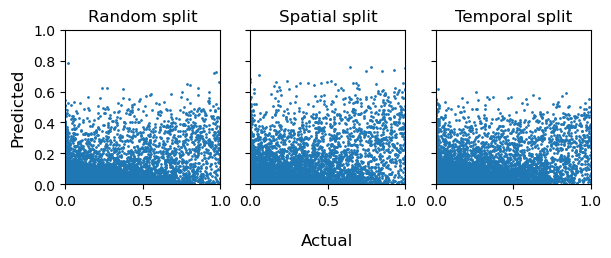

In [16]:
def one_to_one_plot(y_actual, y_predicted, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()
        
    ax.scatter(y_actual, y_predicted, **kwargs)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect("equal")
    return ax

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(6, 3), layout="constrained")

scatter_args = dict(s=1)

one_to_one_plot(y_actual, y_hat_random, ax=ax[0], **scatter_args)
one_to_one_plot(y_actual, y_hat_spatial, ax=ax[1], **scatter_args)
one_to_one_plot(y_actual, y_hat_temporal, ax=ax[2], **scatter_args)

ax[0].set_title("Random split")
ax[1].set_title("Spatial split")
ax[2].set_title("Temporal split")

fig.supxlabel("Actual", y=0.03, x=0.535)
fig.supylabel("Predicted")

plt.show()

### Performance metrics

In [17]:
nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError()
nrmse_random = nrmse(torch.from_numpy(y_actual), torch.from_numpy(y_hat_random)).item()
nrmse_spatial = nrmse(torch.from_numpy(y_actual), torch.from_numpy(y_hat_spatial)).item()
nrmse_temporal = nrmse(torch.from_numpy(y_actual), torch.from_numpy(y_hat_temporal)).item()

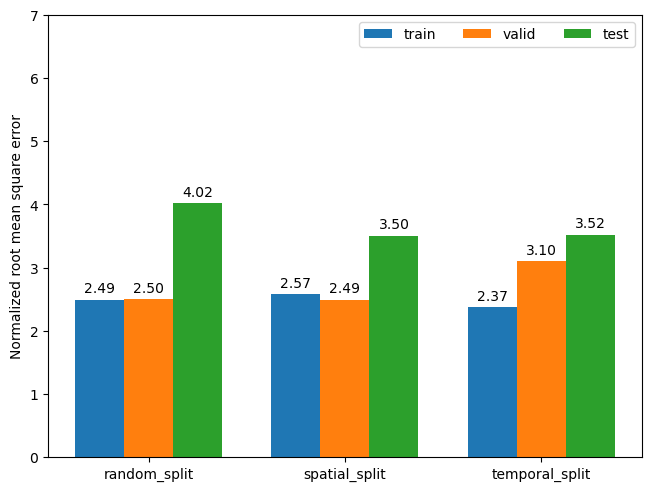

In [18]:
fig, ax = plt.subplots(layout='constrained')

names = list(results.keys())
rmse_key = "NormalizedRootMeanSquaredError()"

metric_dict = {
    "train": [results[n].history["Train"][rmse_key][-1] for n in names],
    "valid": [results[n].history["Valid"][rmse_key][-1] for n in names],
    "test": [nrmse_random, nrmse_spatial, nrmse_temporal]
}

width = 0.25  # the width of the bars
multiplier = 0
x = np.arange(len(metric_dict))

for group, values in metric_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, values, width, label=group)
    ax.bar_label(rects, padding=3, fmt="{:.2f}")
    multiplier += 1

ax.legend(loc="upper right", ncols=3)
ax.set_xticks(x + width, names)
ax.set_ylabel("Normalized root mean square error")
ax.set_ylim(0, 7)
plt.show()

### Map of test predictions by strategy

In [19]:
ds_test = ds_test.copy()
ds_test["random_split_predict"] = y_hat_random
ds_test["spatial_split_predict"] = y_hat_spatial
ds_test["temporal_split_predict"] = y_hat_temporal

ds_test_xr = ds_test.set_index(["latitude", "longitude", "year"]).to_xarray()

In [20]:
ds_test_xr

<xarray.Dataset> Size: 15MB
Dimensions:                 (latitude: 329, longitude: 224, year: 2)
Coordinates:
  * latitude                (latitude) float64 3kB 32.66 32.69 ... 41.98 42.01
  * longitude               (longitude) float64 2kB -124.3 -124.3 ... -116.3
  * year                    (year) int64 16B 2006 2016
Data variables: (12/14)
    fire                    (latitude, longitude, year) float64 1MB nan ... nan
    mort                    (latitude, longitude, year) float64 1MB nan ... nan
    mort1                   (latitude, longitude, year) float64 1MB nan ... nan
    mtemp1                  (latitude, longitude, year) float64 1MB nan ... nan
    near1                   (latitude, longitude, year) float64 1MB nan ... nan
    prec1                   (latitude, longitude, year) float64 1MB nan ... nan
    ...                      ...
    prec4                   (latitude, longitude, year) float64 1MB nan ... nan
    prism_prec              (latitude, longitude, year) float64 1MB nan ... nan
    rhost1                  (latitude, longitude, year) float64 1MB nan ... nan
    random_split_predict    (latitude, longitude, year) float32 590kB nan ......
    spatial_split_predict   (latitude, longitude, year) float32 590kB nan ......
    temporal_split_predict  (latitude, longitude, year) float32 590kB nan ......

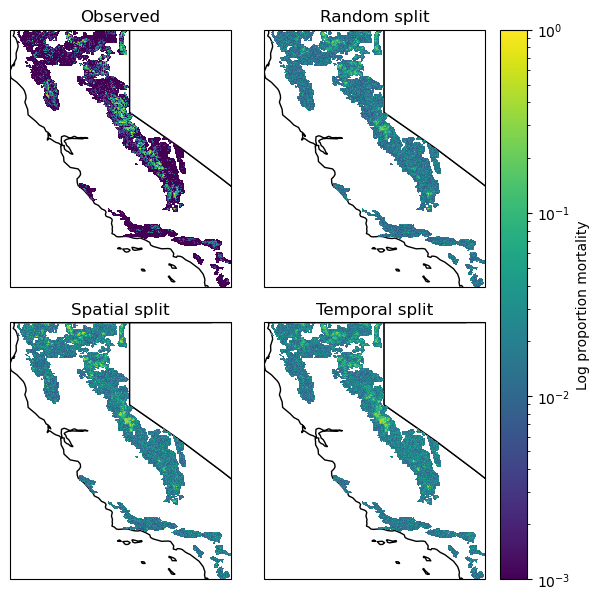

In [21]:
from matplotlib.colors import LogNorm
import cartopy.feature as cfeature

mercator_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(2, 2, figsize=(6, 6), subplot_kw=dict(projection=mercator_proj))


# Add state borders
state_borders = cfeature.NaturalEarthFeature(
    category='cultural', 
    name='admin_1_states_provinces_lakes', 
    scale='50m', facecolor='#FFFFFF'
)

for a in ax.ravel():
    a.add_feature(state_borders, edgecolor="black", zorder=0)

# Draw predictions
eps = 1e-3
norm = LogNorm(vmin=eps, vmax=1)

_  = (ds_test_xr.mort + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[0, 0], norm=norm, add_colorbar=False)
_  = (ds_test_xr.random_split_predict + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[0, 1], norm=norm, add_colorbar=False)
_  = (ds_test_xr.spatial_split_predict + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[1, 0], norm=norm, add_colorbar=False)
im = (ds_test_xr.temporal_split_predict + eps).isel(year=0).plot(x="longitude", y="latitude", ax=ax[1, 1], norm=norm, add_colorbar=False)

plt.tight_layout()
fig.colorbar(im, ax=ax[:, 1], location="right", label="Log proportion mortality")

# Labels
ax[0, 0].set_title("Observed")
ax[0, 1].set_title("Random split")
ax[1, 0].set_title("Spatial split")
ax[1, 1].set_title("Temporal split")

plt.show()

### Modeling extents

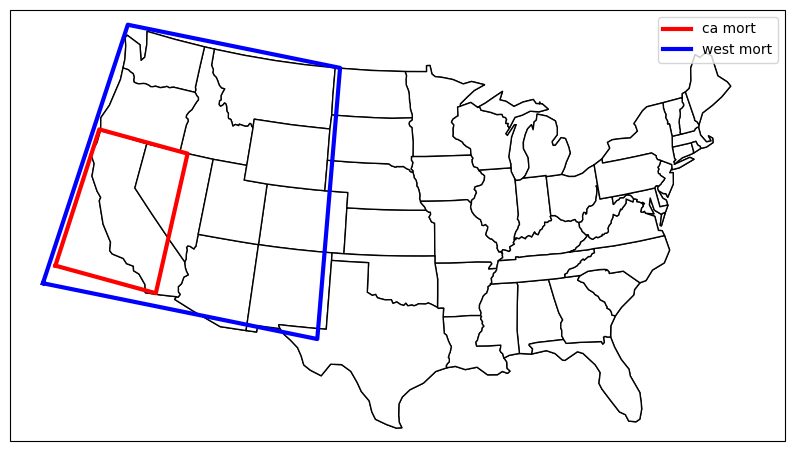

In [22]:
import cartopy.io.shapereader as shpreader
import matplotlib.patches as mpatches

west_xmin, west_ymin, west_xmax, west_ymax = (-124.83182873097032, 31.31942505180775, -103.62260487290841, 49.0320562417854)

ca_xmin, ca_ymin, ca_xmax, ca_ymax = (
    ds_test_xr.longitude.min().values,
    ds_test_xr.latitude.min().values,
    ds_test_xr.longitude.max().values,
    ds_test_xr.latitude.max().values
)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.LambertConformal())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(
    resolution='110m',
    category='cultural', 
    name=shapename
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=lambda x: {"facecolor": "#FFFFFF", "edgecolor": "black"}
)

ax.plot(
    [ca_xmin, ca_xmax, ca_xmax, ca_xmin, ca_xmin],
    [ca_ymin, ca_ymin, ca_ymax, ca_ymax, ca_ymin],
    color="red",
    linewidth=3,
    transform=ccrs.Geodetic(),
    label="ca mort"
)


ax.plot(
    [west_xmin, west_xmax, west_xmax, west_xmin, west_xmin],
    [west_ymin, west_ymin, west_ymax, west_ymax, west_ymin],
    color="blue",
    linewidth=3,
    transform=ccrs.Geodetic(),
    label="west mort"
)

ax.set_extent([-125, -70, 25, 50], crs=ccrs.PlateCarree())
plt.legend()
plt.show()